In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [3]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [4]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates

In [5]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [6]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [7]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [8]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [9]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover

In [10]:
HPI_PO

,DATE,YoY,Implied_Turnover
0,1992-01-01,2.35603,NaN
1,1992-04-01,2.14440,NaN
2,1992-07-01,2.77548,NaN
3,1992-10-01,2.74108,NaN
4,1993-01-01,1.53561,NaN
...,...,...,...
116,2021-01-01,13.08681,6.684530
117,2021-04-01,17.81826,6.321918
118,2021-07-01,18.60512,6.440745
119,2021-10-01,17.70045,6.539117


In [11]:
HPI_PO["YoY_MA_5"] = HPI_PO.YoY.rolling(5).mean()

In [12]:
HPI_PO

,DATE,YoY,Implied_Turnover,YoY_MA_5
0,1992-01-01,2.35603,NaN,NaN
1,1992-04-01,2.14440,NaN,NaN
2,1992-07-01,2.77548,NaN,NaN
3,1992-10-01,2.74108,NaN,NaN
4,1993-01-01,1.53561,NaN,2.310520
...,...,...,...,...
116,2021-01-01,13.08681,6.684530,8.903530
117,2021-04-01,17.81826,6.321918,11.219404
118,2021-07-01,18.60512,6.440745,13.788192
119,2021-10-01,17.70045,6.539117,15.676364


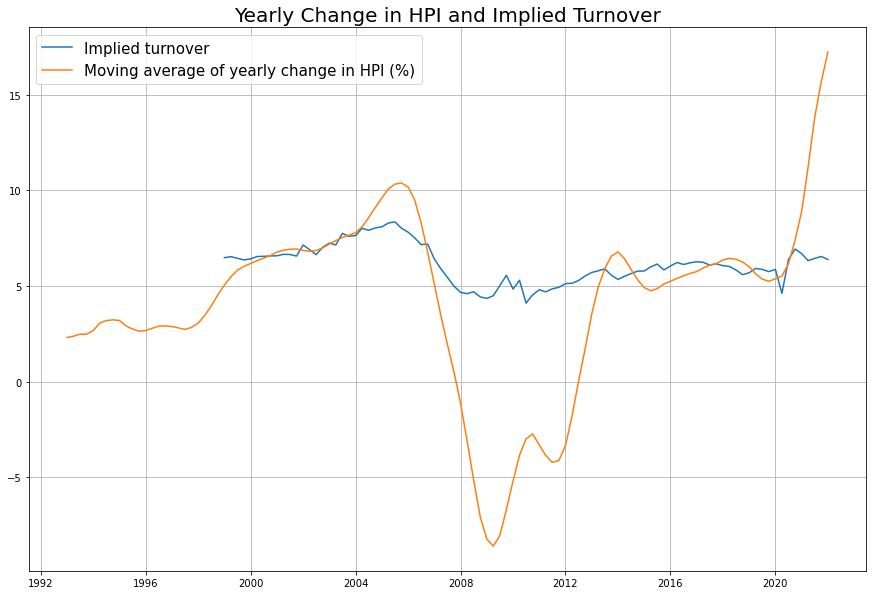

In [13]:
plt.figure(figsize=(15,10))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover.values, label = "Implied turnover")
plt.plot(HPI_PO.DATE, HPI_PO.YoY_MA_5, label = "Moving average of yearly change in HPI (%)")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Yearly Change in HPI and Implied Turnover", size = 20);

In [14]:
HPI_df = HPI_PO.dropna().reset_index(drop=True)

In [15]:
HPI_df

,DATE,YoY,Implied_Turnover,YoY_MA_5
0,1999-01-01,5.93694,6.477936,5.049380
1,1999-04-01,6.02527,6.529750,5.471682
2,1999-07-01,6.29097,6.447134,5.824094
3,1999-10-01,6.14804,6.359195,6.021422
4,2000-01-01,6.46462,6.412796,6.173168
...,...,...,...,...
88,2021-01-01,13.08681,6.684530,8.903530
89,2021-04-01,17.81826,6.321918,11.219404
90,2021-07-01,18.60512,6.440745,13.788192
91,2021-10-01,17.70045,6.539117,15.676364


In [16]:
size=int(HPI_df.shape[0]*0.8)

In [17]:
train, test = HPI_df.iloc[:size,:], HPI_df.iloc[size:,:]

In [18]:
X_train, y_train = train['YoY_MA_5'], train['Implied_Turnover']
X_test, y_test = test['YoY_MA_5'], test['Implied_Turnover']

In [19]:
X_train=np.array(X_train).reshape(-1, 1)
X_test= np.array(X_test).reshape(-1, 1)

In [20]:
from sklearn.linear_model import LinearRegression

# Fit and predict
model = LinearRegression()  
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_fore = model.predict(X_test)

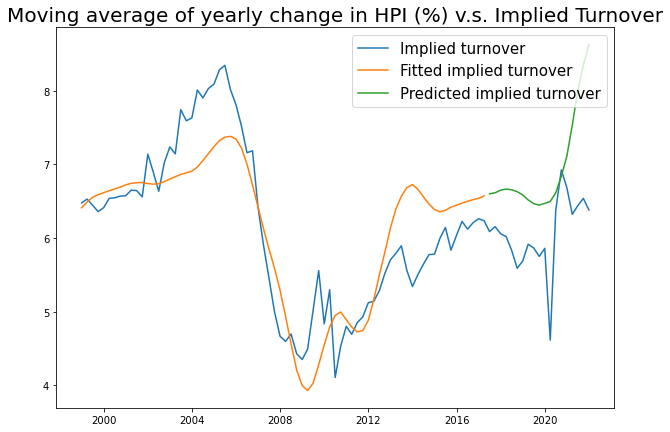

In [21]:
plt.figure(figsize=(10,7))
plt.plot(HPI_df.DATE, HPI_df.Implied_Turnover.values, label = "Implied turnover")
plt.plot(train.DATE, y_pred, label = "Fitted implied turnover")
plt.plot(test.DATE, y_fore, label = "Predicted implied turnover")
plt.legend(fontsize = 15)
plt.title("Moving average of yearly change in HPI (%) v.s. Implied Turnover", size = 20);

Now let us see some statistics results. 

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
mae = mean_absolute_error(y_test, y_fore)
mse = mean_squared_error(y_test, y_fore)
rmse = np.sqrt(mse)

In [24]:
print(f'Mean absolute error: {mae:.5f}')
print(f'Mean squared error: {mse:.5f}')
print(f'Root mean squared error: {rmse:.5f}')

Mean absolute error: 0.89217
Mean squared error: 1.12733
Root mean squared error: 1.06176


Now I am going to include housing credit availability index

In [25]:
HCAI = pd.read_csv("HCAI_WM.csv")

In [26]:
HCAI.dropna(inplace=True)

In [27]:
HCAI.columns

Index(['Year', 'Quarter', 'Total\nRisk', 'Borrower\nRisk', 'Product\nRisk'], dtype='object')

In [28]:
HCAI.rename(columns = {'Total\nRisk':'Total_Risk', 'Borrower\nRisk':'Borrower_Risk', 'Product\nRisk':'Product_Risk'}, inplace = True)

In [29]:
HCAI = HCAI[4:].reset_index(drop=True)

In [30]:
HCAI

,Year,Quarter,Total_Risk,Borrower_Risk,Product_Risk
0,1999,1,11.236,8.836,2.400
1,1999,2,11.790,9.040,2.750
2,1999,3,13.209,9.471,3.737
3,1999,4,14.332,10.160,4.172
4,2000,1,14.764,10.372,4.393
...,...,...,...,...,...
86,2020,3,4.989,4.986,0.003
87,2020,4,5.082,5.078,0.003
88,2021,1,5.125,5.121,0.004
89,2021,2,5.145,5.138,0.007


In [31]:
HCAI_index = HCAI.index.to_list()
HCAI_Y = HCAI.Year.values
HCAI_Q = HCAI.Quarter.values
Quarter_to_Date = {1 : "-01-01", 2 : "-04-01",  3 : "-07-01", 4 : "-10-01"}
Dates = []
for i in HCAI_index:
    date = str(HCAI_Y[i])+Quarter_to_Date[HCAI_Q[i]]
    Dates.append(date)
HCAI['DATE'] = pd.to_datetime(Dates)

In [32]:
HCAI.drop(['Year', 'Quarter'], axis=1, inplace=True)

In [33]:
HCAI

,Total_Risk,Borrower_Risk,Product_Risk,DATE
0,11.236,8.836,2.400,1999-01-01
1,11.790,9.040,2.750,1999-04-01
2,13.209,9.471,3.737,1999-07-01
3,14.332,10.160,4.172,1999-10-01
4,14.764,10.372,4.393,2000-01-01
...,...,...,...,...
86,4.989,4.986,0.003,2020-07-01
87,5.082,5.078,0.003,2020-10-01
88,5.125,5.121,0.004,2021-01-01
89,5.145,5.138,0.007,2021-04-01


In [34]:
df_hpi_hcai=HPI_df.merge(HCAI, how='left')

In [35]:
df_hpi_hcai.dropna(inplace=True)

In [36]:
df_hpi_hcai

,DATE,YoY,Implied_Turnover,YoY_MA_5,Total_Risk,Borrower_Risk,Product_Risk
0,1999-01-01,5.93694,6.477936,5.049380,11.236,8.836,2.400
1,1999-04-01,6.02527,6.529750,5.471682,11.790,9.040,2.750
2,1999-07-01,6.29097,6.447134,5.824094,13.209,9.471,3.737
3,1999-10-01,6.14804,6.359195,6.021422,14.332,10.160,4.172
4,2000-01-01,6.46462,6.412796,6.173168,14.764,10.372,4.393
...,...,...,...,...,...,...,...
86,2020-07-01,8.25959,6.377489,6.156220,4.989,4.986,0.003
87,2020-10-01,11.17118,6.925938,7.391096,5.082,5.078,0.003
88,2021-01-01,13.08681,6.684530,8.903530,5.125,5.121,0.004
89,2021-04-01,17.81826,6.321918,11.219404,5.145,5.138,0.007


In [37]:
df_hpi_hcai.columns

Index(['DATE', 'YoY', 'Implied_Turnover', 'YoY_MA_5', 'Total_Risk',
       'Borrower_Risk', 'Product_Risk'],
      dtype='object')

In [38]:
features = ['YoY_MA_5', 'Total_Risk']

In [39]:
size=int(df_hpi_hcai.shape[0]*0.8)

In [40]:
train1, test1 = df_hpi_hcai.iloc[:size,:], df_hpi_hcai.iloc[size:,:]

In [41]:
X1_train, y1_train = train1[features], train1['Implied_Turnover']
X1_test, y1_test = test1[features], test1['Implied_Turnover']

In [42]:
# Fit and predict
model1 = LinearRegression()  
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_train)
y1_fore = model1.predict(X1_test)

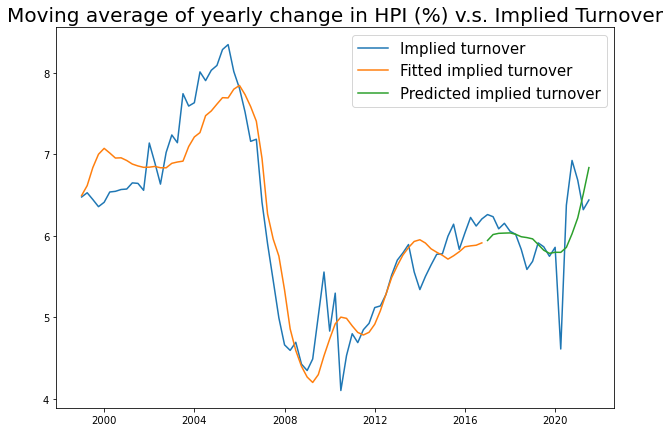

In [43]:
plt.figure(figsize=(10,7))
plt.plot(df_hpi_hcai.DATE, df_hpi_hcai.Implied_Turnover.values, label = "Implied turnover")
plt.plot(train1.DATE, y1_pred, label = "Fitted implied turnover")
plt.plot(test1.DATE, y1_fore, label = "Predicted implied turnover")
plt.legend(fontsize = 15)
plt.title("Moving average of yearly change in HPI (%) v.s. Implied Turnover", size = 20);

In [44]:
mae1 = mean_absolute_error(y1_test, y1_fore)
mse1 = mean_squared_error(y1_test, y1_fore)
rmse1 = np.sqrt(mse1)

In [45]:
print(f'Mean absolute error: {mae1:.5f}')
print(f'Mean squared error: {mse1:.5f}')
print(f'Root mean squared error: {rmse1:.5f}')

Mean absolute error: 0.28253
Mean squared error: 0.17465
Root mean squared error: 0.41791
